# Plots for PicoScope analysis

## Preliminary operations

### Paths

In [1]:
USER_PATH = "/home/rocco/University/APL/Lab/"
DATA_PATH = USER_PATH + "plots/data/picoscope/"
SAVE_PATH = USER_PATH + "plots/plots/"

### Flags

In [2]:
UNZIP_DATA    = False
WAVE2NUMPY    = False
PLOT_WAVE     = False
PLOT_MAV_WAVE = False
REJECT_3SIGMA = False

### Load packages

In [3]:
import os
import ROOT
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.palettes as palette

Welcome to JupyROOT 6.22/06


In [4]:
from ROOT import TF1
from ROOT import TCanvas, TGraph, TGraphErrors

### Settings

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

In [6]:
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

<ipython-input-6-4c3d034b1475>:1: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\boldmath']


In [7]:
col = palette.brewer['RdYlGn'][10]

### Constants

In [8]:
BKG_RATE = 0.2951674822029528 #6.635    # ev/h

***

<br>
<br>
<br>
<br>
<br>

***

## Isotropy plots

### Load data

In [9]:
df_exp = pd.read_csv(DATA_PATH + "pico_data_isotropy.csv")

### Compute weighted average

In [10]:
mean = np.average(df_exp["pico_r"], weights=(1/np.square(df_exp["pico_r_err"])))

### Compute residues

In [11]:
res_num = mean - df_exp["pico_r"]
res_den = df_exp["pico_r_err"]
res     = res_num  / res_den

### Plot and save

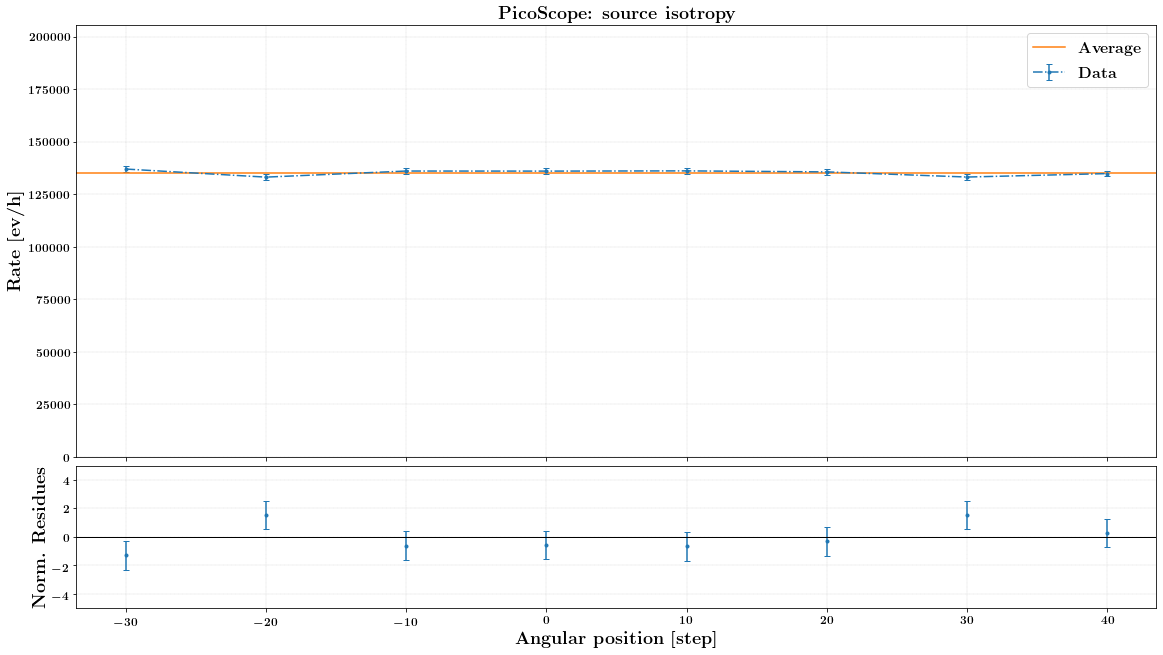

In [12]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(15,6))



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

########## ERRORPLOT OF EXPERIMENTAL DATA
plt.errorbar(
    x               = df_exp["pico_step"],
    y               = df_exp["pico_r"],
    yerr            = df_exp["pico_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

########## PLOT OF WEIGHTED AVERAGE HLINE
plt.axhline(
    y         = mean,
    color     = "C1",
    linewidth = 1.5,
    label     = r"\bf{Average}"
)

########## TOP PANEL SETTINGS
plt.ylim(np.max(df_exp["pico_r"])*0.0, np.max(df_exp["pico_r"])*1.5)
plt.ylabel(r"\bf{Rate [ev/h]}")
plt.title(r"\bf{PicoScope: source isotropy}")
# plt.xlim(-18,18)
plt.xticks(df_exp["pico_step"][df_exp["pico_step"] % 10 == 0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend()
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### BOTTOM PANEL
#######################################################################
fig.add_axes((0.,0.,1.0,0.33))

########## ERRORPLOT OF RESIDUES
plt.errorbar(
    x               = df_exp["pico_step"],
    y               = res,
    # xerr            = df_sim["pico_step_err"],
    yerr            = np.ones(df_exp.shape[0]),
    fmt             ='o',
    markersize      = 3,
    capsize         = 3,
    # markerfacecolor = "red",
    # color           = "red",
    # ecolor          = "red",
    label           = r"\bf{Norm. Residues}",
    alpha           = 1
)

########## ZERO HLINE FOR RESIDUES
plt.axhline(y=0, color="black", linewidth=1)

########## BOTTOM PANEL SETTINGS
plt.ylim(-5,5)
plt.ylabel(r"\bf{Norm. Residues}")
plt.xlabel(r"\bf{Angular position [step]}")
plt.xticks(df_exp["pico_step"][df_exp["pico_step"] % 10 == 0])
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "picoscope/source_isotropy.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

***

<br>
<br>
<br>
<br>
<br>

***

## Beam profile plots

### Load data

#### Experimental data

In [13]:
df_exp = pd.read_csv(DATA_PATH + "pico_data_profile.csv")

#### Simulated data: load

In [14]:
df_sim = np.loadtxt(DATA_PATH + "pico_sim_profile.txt")

#### Simulated data: shift correction

In [15]:
shift       = np.average(df_exp["pico_step"], weights=df_exp["pico_r"])
df_sim[:,0] = df_sim[:,0] / 0.9 + shift

#### Simulated data: grouping + normalization

In [16]:
# group simulated data into the experimental data format (group by step)
sim_steps = []
sim_ev    = []
for step in df_exp["pico_step"]:
    ev = 0
    for i in range(df_sim.shape[0]-1):
        if (step >= df_sim[i,0]) and (step <= df_sim[i+1,0]):
            m  = (df_sim[i+1,1] - df_sim[i,1]) / (df_sim[i+1,0] - df_sim[i,0])
            ev = df_sim[i,1] + m * (step-df_sim[i,0])
            
    sim_steps.append(step)
    sim_ev.append(ev)

sim_steps = np.array(sim_steps)
sim_ev    = np.array(sim_ev)

# normalization
num = np.sum(df_exp["pico_r"]) # np.mean(df_exp["pico_r"][np.abs(df_exp["pico_step"])<=2])
den = np.sum(sim_ev)           # np.mean(sim_ev[np.abs(sim_steps)<=2])

sim_norm = num / den

#### Simulated data: put in dataframe

In [17]:
d_sim = {
    "pico_step"     : sim_steps,
    # "pico_rad"      : pico_rad,
    # "pico_deg"      : pico_deg,
    # "pico_seg"      : pico_seg,
    "pico_ev"       : sim_ev,
    # "pico_t"        : pico_t,
    "pico_r"        : sim_ev * sim_norm,
    # "pico_step_err" : pico_step_err,
    # "pico_rad_err"  : pico_rad_err,
    # "pico_deg_err"  : pico_deg_err,
    "pico_ev_err"   : np.sqrt(sim_ev),
    "pico_r_err"    : np.sqrt(sim_ev) * sim_norm
}

df_sim = pd.DataFrame(data=d_sim)
df_sim = df_sim.sort_values(by=['pico_step'])

### Subtract background

In [18]:
df_exp["pico_r"] = df_exp["pico_r"] - BKG_RATE

### Compute residues

In [19]:
res_num =                   df_sim["pico_r"]      -           df_exp["pico_r"]
res_den = np.sqrt(np.square(df_sim["pico_r_err"]) + np.square(df_exp["pico_r_err"]))
res     = res_num  / res_den

### Plot and save

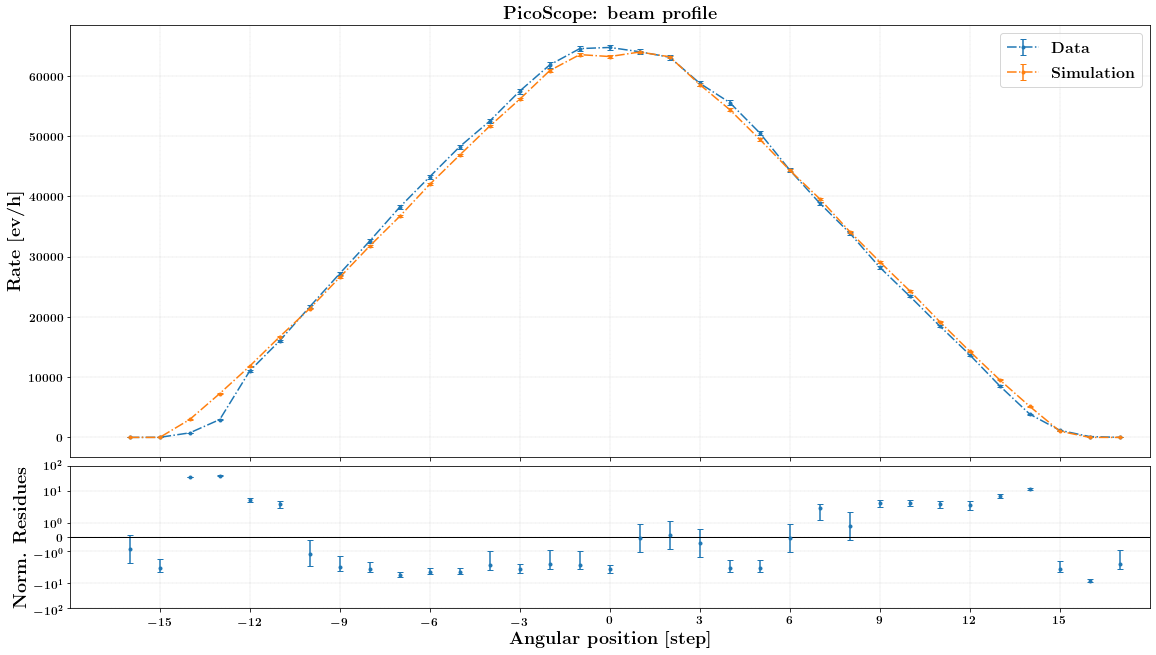

In [20]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(15,6))



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

########## ERRORPLOT OF EXPERIMENTAL DATA
plt.errorbar(
    x               = df_exp["pico_step"],
    y               = df_exp["pico_r"],
    yerr            = df_exp["pico_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

########## ERRORPLOT OF SIMULATED DATA
plt.errorbar(
    x               = df_sim["pico_step"],
    y               = df_sim["pico_r"],
    yerr            = df_sim["pico_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Simulation}",
    alpha           = 1
)

########## TOP PANEL SETTINGS
plt.ylabel(r"\bf{Rate [ev/h]}")
plt.title(r"\bf{PicoScope: beam profile}")
plt.xlim(-18,18)
plt.xticks(df_exp["pico_step"][df_exp["pico_step"] % 3 == 0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.legend()
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### BOTTOM PANEL
#######################################################################
fig.add_axes((0.,0.,1.0,0.33))

########## ERRORPLOT OF RESIDUES
plt.errorbar(
    x               = df_sim["pico_step"],
    y               = res,
    yerr            = np.ones(df_sim.shape[0]),
    fmt             ='o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Residues}",
    alpha           = 1
)

########## ZERO HLINE FOR RESIDUES
plt.axhline(y=0, color="black", linewidth=1)

########## BOTTOM PANEL SETTINGS
plt.xlim(-18,18)
plt.ylim(-100,100)
plt.yscale("symlog")
plt.ylabel(r"\bf{Norm. Residues}")
plt.xlabel(r"\bf{Angular position [step]}")
plt.xticks(df_exp["pico_step"][df_exp["pico_step"] % 3 == 0])
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "picoscope/beam_profile.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

***

<br>
<br>
<br>
<br>
<br>

***

## Scattering profile plots

### Load data

#### Experimental data

In [21]:
df_exp = pd.read_csv(DATA_PATH + "pico_data_gold.csv")

#### Simulated data: load

In [22]:
df_sim = np.loadtxt(DATA_PATH + "pico_sim_gold.txt")

#### Simulated data: shift correction

In [23]:
shift       = np.average(df_exp["pico_step"], weights=df_exp["pico_r"])
df_sim[:,0] = df_sim[:,0] / 0.9 + shift

#### Simulated data: grouping + normalization

In [24]:
# group simulated data into the experimental data format (group by step)
sim_steps = []
sim_ev    = []
for step in df_exp["pico_step"]:
    ev = 0
    for i in range(df_sim.shape[0]-1):
        if (step >= df_sim[i,0]) and (step <= df_sim[i+1,0]):
            m  = (df_sim[i+1,1] - df_sim[i,1]) / (df_sim[i+1,0] - df_sim[i,0])
            ev = df_sim[i,1] + m * (step-df_sim[i,0])
            
    sim_steps.append(step)
    sim_ev.append(ev)

sim_steps = np.array(sim_steps)
sim_ev    = np.array(sim_ev)

# normalization
num = np.sum(df_exp["pico_r"]) # np.mean(df_exp["pico_r"][np.abs(df_exp["pico_step"])<=2])
den = np.sum(sim_ev)           # np.mean(sim_ev[np.abs(sim_steps)<=2])

sim_norm = num / den

#### Simulated data: put in dataframe

In [25]:
d_sim = {
    "pico_step"     : sim_steps,
    # "pico_rad"      : pico_rad,
    # "pico_deg"      : pico_deg,
    # "pico_seg"      : pico_seg,
    "pico_ev"       : sim_ev,
    # "pico_t"        : pico_t,
    "pico_r"        : sim_ev * sim_norm,
    # "pico_step_err" : pico_step_err,
    # "pico_rad_err"  : pico_rad_err,
    # "pico_deg_err"  : pico_deg_err,
    "pico_ev_err"   : np.sqrt(sim_ev),
    "pico_r_err"    : np.sqrt(sim_ev) * sim_norm
}

df_sim = pd.DataFrame(data=d_sim)
df_sim = df_sim.sort_values(by=['pico_step'])

### Subtract background

In [26]:
df_exp["pico_r"] = df_exp["pico_r"] - BKG_RATE

### Compute residues

In [27]:
res_num =                   df_sim["pico_r"]      -           df_exp["pico_r"]
res_den = np.sqrt(np.square(df_sim["pico_r_err"]) + np.square(df_exp["pico_r_err"]))
res     = res_num  / res_den

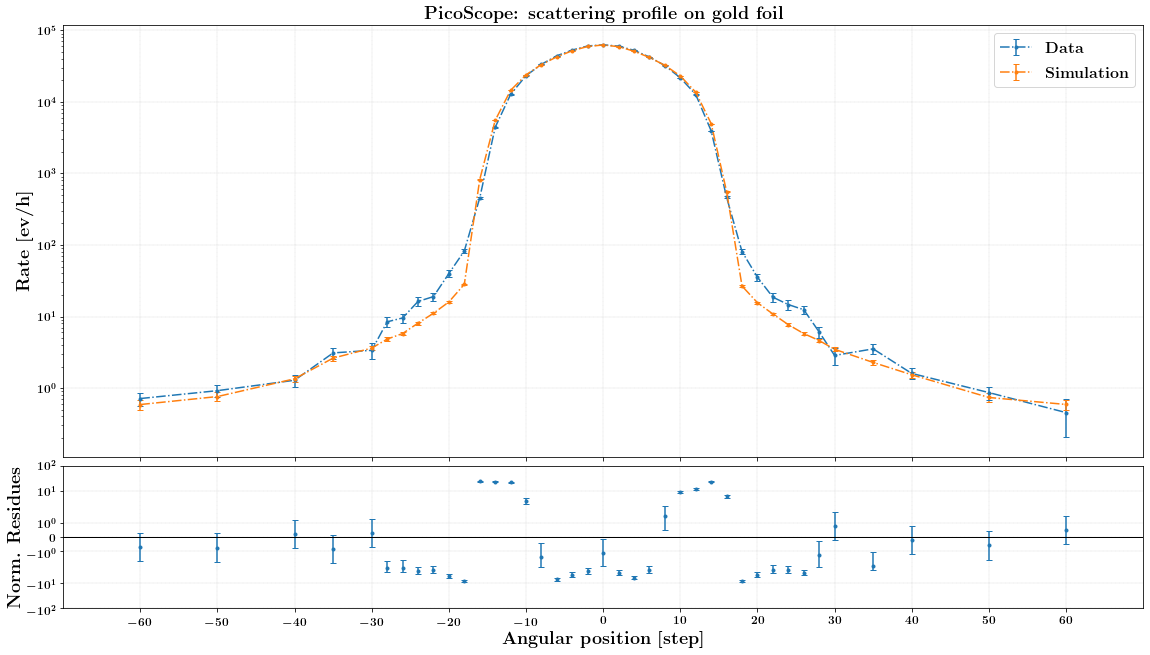

In [28]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(15,6))



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

########## ERRORPLOT OF EXPERIMENTAL DATA
plt.errorbar(
    x               = df_exp["pico_step"],
    y               = df_exp["pico_r"],
    yerr            = df_exp["pico_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

########## ERRORPLOT OF SIMULATED DATA
plt.errorbar(
    x               = df_sim["pico_step"],
    y               = df_sim["pico_r"],
    yerr            = df_sim["pico_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Simulation}",
    alpha           = 1
)

########## TOP PANEL SETTINGS
plt.yscale("log")
plt.ylabel(r"\bf{Rate [ev/h]}")
plt.title(r"\bf{PicoScope: scattering profile on gold foil}")
plt.xlim(-70,70)
plt.xticks(df_exp["pico_step"][df_exp["pico_step"] % 10 == 0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.legend()
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### BOTTOM PANEL
#######################################################################
fig.add_axes((0.,0.,1.0,0.33))

########## ERRORPLOT OF RESIDUES
plt.errorbar(
    x               = df_sim["pico_step"],
    y               = res,
    yerr            = np.ones(df_sim.shape[0]),
    fmt             ='o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Residues}",
    alpha           = 1
)

########## ZERO HLINE FOR RESIDUES
plt.axhline(y=0, color="black", linewidth=1)

########## BOTTOM PANEL SETTINGS
plt.xlim(-70,70)
plt.ylim(-100,100)
plt.yscale("symlog")
plt.ylabel(r"\bf{Norm. Residues}")
plt.xlabel(r"\bf{Angular position [step]}")
plt.xticks(df_exp["pico_step"][df_exp["pico_step"] % 10 == 0])
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "picoscope/gold_scattering_profile.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################